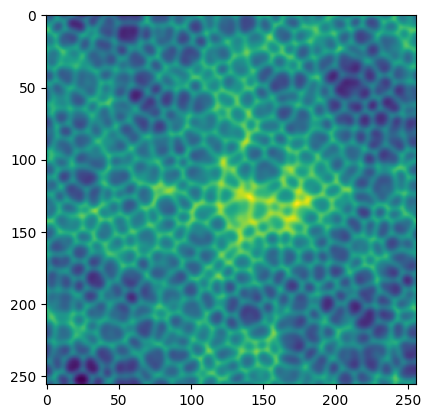

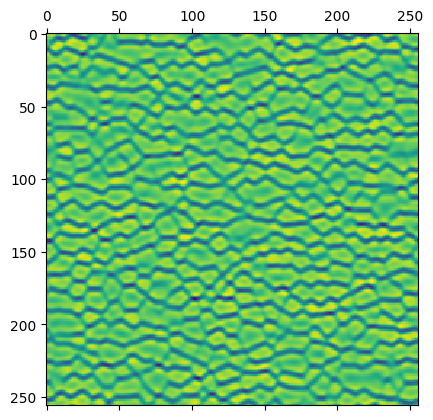

In [21]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import torch.nn.functional as F

d = np.load("../ks2d/ks2d_short.npy")
d = torch.tensor(d)

plt.imshow(d[0,...])

# coefficients
# dx = [-1/60, 3/20, -3/4, 0, 3/4, -3/20, 1/60] 

dxx = torch.tensor([1/90, -3/20, 3/2, -49/18, 3/2, -3/20, 1/90]).double()
dxxxx = torch.tensor([7/240, -2/5, 169/60, -122/15, 91/8, -122/15, 169/60, -2/5, 7/240 ]).double()


kernel = dxx.flip(0).view(1,1,-1)
ks = kernel.shape[2]
ell = (ks-1)//2

# first axis
N0, N1 = d.shape[1:]
d_ = torch.cat((d[:,-ell:,:], d, d[:,:ell,:]), dim=1)
d_ = d_.permute(0,2,1)
d_ = d_.reshape(-1, 1, N0+2*ell)
d_ = F.conv1d(d_, kernel)
d_ = d_.reshape(-1, N1, N0).permute(0,2,1)

plt.matshow(d_[0,...])